In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy as hp
from healpy.visufunc import projplot
import fitsio
import itertools as it
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, angular_separation, Angle
import astropy.units as u
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
import dipole

### healpix parameters

In [5]:
NSIDE = 64

### CatWISE

In [59]:
# CatWISE overdensity map

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
                    blim=15, maglim=16.4, load_init=True)
d = SecrestDipole(**catwise_kwargs)
d.cut_mag()
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

# fit dipole (and other multipoles) from blim=30 map
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= 30] = 1
mask_blim30 = gal_plane_mask.astype(bool) & small_masks.astype(bool)
masked_datamap_blim30 = np.multiply(datamap, mask_blim30, where=(mask_blim30!=0), out=np.full_like(datamap, np.nan))

# OVERDENSITIES
overdensity_map_catwise = masked_datamap_blim30 / np.nanmean(masked_datamap_blim30) - 1

loading initial catalog, catwise_agns_master.fits
8532854 sources in initial catalog.
cut w1 > 16.4 -> 3079981 sources left.


In [60]:
# smooth map (steradian scale)
smoothed_map = tools.smooth_map(masked_datamap)

In [63]:
# contour line at blim: just make an array of points because healpy is annoying
blim = 30
lons = np.linspace(0, 360, 201)
lats = np.ones_like(lons) * blim

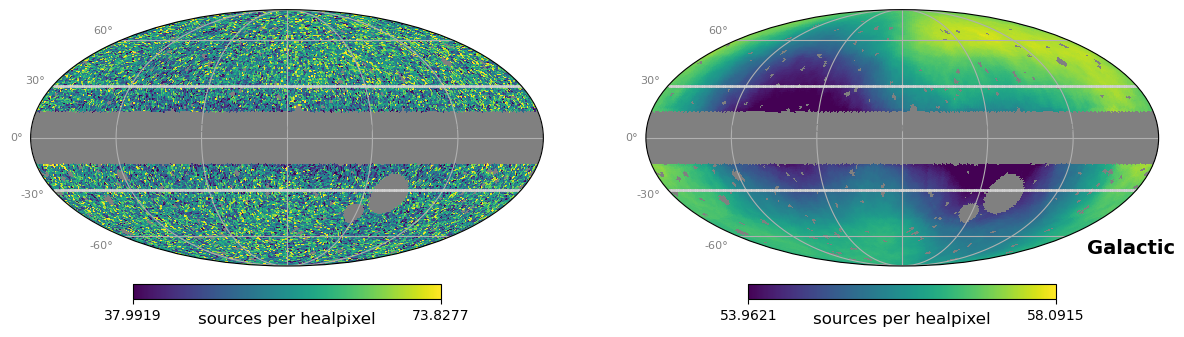

In [64]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], graticule=True, graticule_labels=True,
             xtick_label_color='grey', ytick_label_color='grey', fontsize={'xtick_label':8, 'ytick_label':8},
             unit='sources per healpixel')
mean, std = np.nanmean(masked_datamap), np.nanstd(masked_datamap)
hp.projview(masked_datamap, sub=(1,2,1), min=mean-2*std, max=mean+2*std, **kwargs)

contour_kwargs = dict(c='lightgrey', marker='_', ms=3, alpha=0.8)
for x in zip(lons,lats):
    tools.plot_marker(x[0], x[1], **contour_kwargs)
    tools.plot_marker(x[0], -x[1], **contour_kwargs)
mean, std = np.nanmean(smoothed_map), np.nanstd(smoothed_map)
hp.projview(smoothed_map, sub=(1,2,2), min=mean-2*std, max=mean+2*std, **kwargs)
for x in zip(lons,lats):
    tools.plot_marker(x[0], x[1], **contour_kwargs)
    tools.plot_marker(x[0], -x[1], **contour_kwargs)
tools.label_coord(plt.gca(), 'Galactic')

### Quaia

In [65]:
# Quaia overdensity map

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=15, maglim=20., save_tag='_r1.0', load_init=True, compcorrect=False)
d = SecrestDipole(**quaia_kwargs)
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)

# and load selection function
selfunc = d.load_selfunc()

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
datamap_corr = np.divide(datamap, selfunc, where=(selfunc>0.5), out=np.full_like(datamap, np.nan))
masked_datamap = np.multiply(datamap_corr, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

# fit dipole (and other multipoles) from blim=30 map
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= 30] = 1
mask_blim30 = gal_plane_mask.astype(bool) & small_masks.astype(bool)
datamap_corr = np.divide(datamap, selfunc, where=(selfunc>0.5), out=np.full_like(datamap, np.nan))
masked_datamap_blim30 = np.multiply(datamap_corr, mask_blim30, where=(mask_blim30!=0),
                                    out=np.full_like(datamap, np.nan))

# OVERDENSITIES
overdensity_map_quaia = masked_datamap_blim30 / np.nanmean(masked_datamap_blim30) - 1

loading initial catalog, quaia_G20.0.fits
755850 sources in initial catalog.


In [9]:
# smooth map (steradian scale)
smoothed_map = tools.smooth_map(masked_datamap)

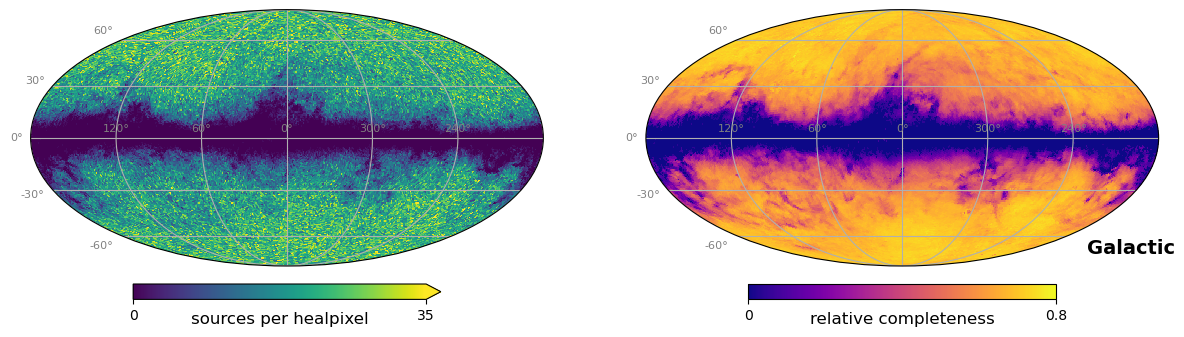

In [18]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], graticule=True, graticule_labels=True,
             xtick_label_color='grey', ytick_label_color='grey', fontsize={'xtick_label':8, 'ytick_label':8})
mean, std = np.nanmean(datamap), np.nanstd(datamap)
hp.projview(datamap, sub=(1,2,1), min=0, max=35, unit='sources per healpixel', **kwargs)
hp.projview(selfunc, sub=(1,2,2), cmap='plasma', min=0, max=0.8, unit='relative completeness', **kwargs)
tools.label_coord(plt.gca(), 'Galactic')

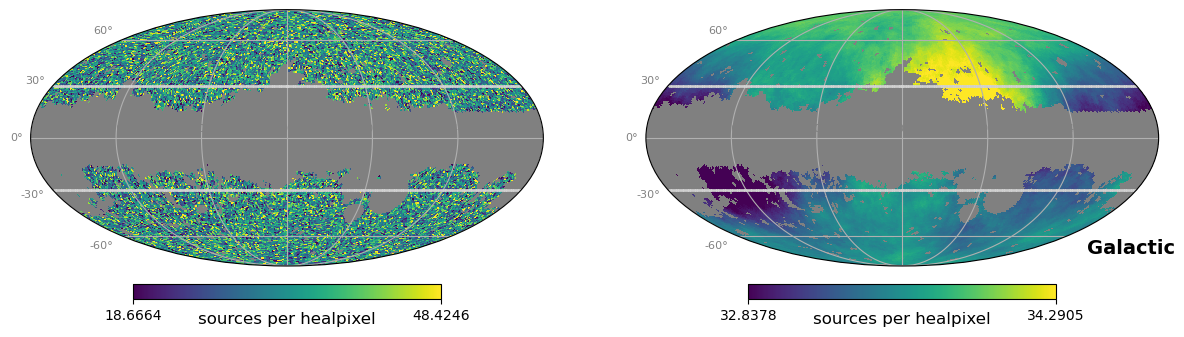

In [58]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], graticule=True, graticule_labels=True,
             xtick_label_color='grey', ytick_label_color='grey', fontsize={'xtick_label':8, 'ytick_label':8},
             unit='sources per healpixel')
mean, std = np.nanmean(masked_datamap), np.nanstd(masked_datamap)
hp.projview(masked_datamap, sub=(1,2,1), min=mean-2*std, max=mean+2*std, **kwargs)

contour_kwargs = dict(c='lightgrey', marker='_', ms=3, alpha=0.8)
for x in zip(lons,lats):
    tools.plot_marker(x[0], x[1], **contour_kwargs)
    tools.plot_marker(x[0], -x[1], **contour_kwargs)
mean, std = np.nanmean(smoothed_map), np.nanstd(smoothed_map)
hp.projview(smoothed_map, sub=(1,2,2), min=mean-2*std, max=mean+2*std, **kwargs)
for x in zip(lons,lats):
    tools.plot_marker(x[0], x[1], **contour_kwargs)
    tools.plot_marker(x[0], -x[1], **contour_kwargs)
tools.label_coord(plt.gca(), 'Galactic')

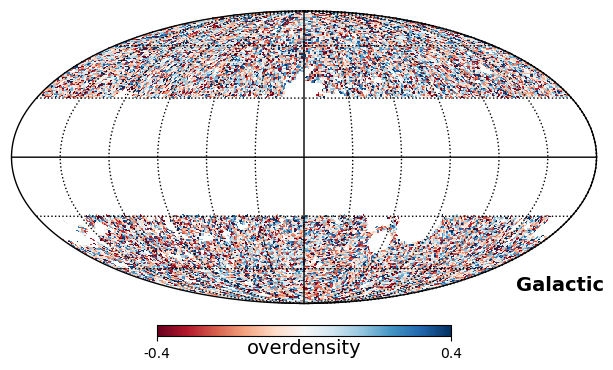

In [74]:
# overdensity map
fig = plt.figure(figsize=(12,4))
hp.mollview(overdensity_map_quaia, coord=['C','G'], badcolor='w', min=-0.4, max=0.4,
            title='', unit='overdensity', cmap='RdBu', sub=(1,2,1))
hp.graticule()

### CMB dipole

In [84]:
# CMB dipole direction, and expected amplitudes for each sample from EB84
_, cmb_dipdir = dipole.cmb_dipole()

# convert (l,b) to a 3D vector on the sky
vec_qso  = hp.ang2vec(cmb_dipdir.galactic.l.deg, cmb_dipdir.galactic.b.deg, lonlat=True)
# vector for every healpixel on the sky
vecs = hp.pix2vec(NSIDE, np.arange(hp.nside2npix(NSIDE))) # NSIDE defined at beginning of notebook

# cosine between every healpixel and the dipole peak
costheta = np.dot(np.array(vecs).T, vec_qso)

# galactic plane mask
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
gal_plane_mask = np.zeros_like(costheta)
gal_plane_mask[np.abs(lat) < 30] = 1

# galactic plane mask
costheta[np.where(gal_plane_mask)] = np.nan

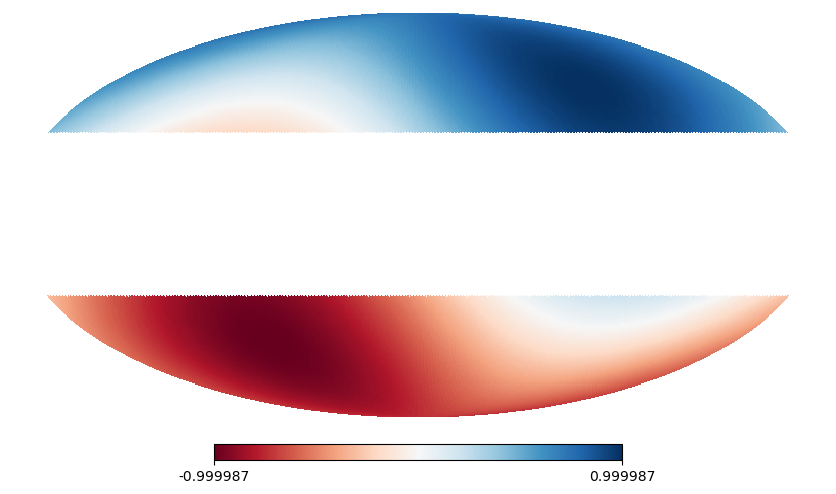

In [87]:
hp.mollview(costheta, title='', badcolor='w', cmap='RdBu')